# Cross-validation tutorial

Duncan Callaway

## Introduction.
This notebook will take us through some of the basics of cross-validation.  Along the way we'll learn a little about how to *resample* data.  

And from an applied perspective, we'll explore the differences between indoor and outdoor PM concentrations.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
os.listdir()

['in_vs_out.png',
 '.DS_Store',
 'parkside.csv',
 'Icon\r',
 'westoak.csv',
 'sensor_map.pdf',
 'sensor_map.png',
 'hilltop.csv',
 'kirchy.csv',
 "Duncan's Lecture 18 notebook.ipynb",
 'blaster.csv',
 '.ipynb_checkpoints',
 'CV_MSE_vs_NumberNeighbors.png',
 'W8.1 notebook.ipynb']

In this directory are five data files.  These are taken from PM sensors in the East Bay.  Two are indoor air sensors:
- parkside
- kirchy

The three others are outdoor sensors:

- westoak
- hilltop
- blaster

Here's a map:
![alt text](sensor_map.png "Title")

## A question

If I care about exposure to particulate matter in my house, can I use nearby outdoor sensors as a proxy?

**In other words, how well does outdoor PM concentration predict indoor?**

## Loading the data.
Let's create a list of strings that name each sensor -- this will help automate the loading and processing of the data:

In [3]:
places = ['parkside', 'westoak', 'blaster', 'hilltop', 'kirchy']

The next loop will go through each of the strings in `places` and 
- load the data, 
- create a datetime vector from the time *string* in the csv files (this takes a while computationally)
- filter out data points before Sept 23rd
- create a Series from the PM2.5 data only

In [4]:
for p in places:

    # load the data:
    df = pd.read_csv(p + '.csv')
    
    # create a datetime column
    df['time'] = pd.to_datetime(df['created_at'], utc=True)
    
    # filter out early measurements
    bool = df['time'] > '2018-09-23'
    df = df.loc[bool,:]
    
    # create the series
    df_series = pd.Series(df.loc[:,'PM2.5_CF_ATM_ug/m3'])
    df_series.index = df['time']
    
    # The `exec` function below allows me to create variables from the strings in `places`
    exec (p + "= df_series")

Let's look at the tops of these new series:

In [5]:
#delete for in-lecture notebook
kirchy.head()

time
2018-09-23 00:00:49+00:00    6.61
2018-09-23 00:02:09+00:00    5.37
2018-09-23 00:03:29+00:00    6.13
2018-09-23 00:04:49+00:00    4.33
2018-09-23 00:06:09+00:00    5.00
Name: PM2.5_CF_ATM_ug/m3, dtype: float64

In [6]:
#delete for in-lecture notebook
hilltop.head()

time
2018-09-23 00:00:47+00:00    5.14
2018-09-23 00:02:07+00:00    5.62
2018-09-23 00:03:27+00:00    5.02
2018-09-23 00:04:47+00:00    4.95
2018-09-23 00:06:07+00:00    5.48
Name: PM2.5_CF_ATM_ug/m3, dtype: float64

**Some Questions**

1. What's the granularity of the data in time?  
2. What problems will we run into if we fit models relating one measurement to the other?

**Some Answers:**

1. About once per minute, but not exactly
2. The measurements are not coincident. Therefore we can't faithfully relate one to the other.

Now, note that we don't know that the clocks of these sensors are synchronized -- but they are internet-connected, so we're going to assume they're close.

To address this we'll use pandas' `resample` method, which aggregates data situated in time into blocks of time of fixed length.  In our case we'll aggregate by averaging all data in a particular window.

In [7]:
#delete for in-lecture notebook
agg = '5min' # this will create a five minute averaging window
hilltop_5min = hilltop.resample(agg).mean()
hilltop_5min.head()

time
2018-09-23 00:00:00+00:00    5.182500
2018-09-23 00:05:00+00:00    5.916667
2018-09-23 00:10:00+00:00    4.722500
2018-09-23 00:15:00+00:00    5.367500
2018-09-23 00:20:00+00:00    4.852500
Freq: 5T, Name: PM2.5_CF_ATM_ug/m3, dtype: float64

Now you can see that the time stamps are very regular.  

Note the default is to put all data in the 0-5 minute window in the measurement marked 0, 5-10 minute window into the 5 minute measurement, and so on.

There are a number of other things one can customize in the execution of the function.  Read the documentation...

Now let's apply this to all the data:

Let's do it for all the data:

In [8]:
agg = '30min' # number of minutes into which to average data. Note that I experimented with smaller averaging windows and found some data to be missing

# In the following, bfill replaces any missing data with the data from the following interval.

for p in places:
    exec (p + "_resamp = " + p + ".resample(agg).mean().bfill()")

That just created five series that are "resampled", but let's try to call it "aggregated" since we're referring to resampling as the process of creating new data sets from your full data set.

In this case, all the data in each 30 minute window are averaged to a single value representing the entire 30 minutes.

There are missing data -- so I used the `.bfill()` method.  This way, times when data are missing are given the data point for the next time step.  

I chose 30min as the time window in part to reduce the number of backfill operations.  

## Building the model
Now let's build the KNN model.  

In [9]:
#delete for in-lecture notebook
from sklearn.neighbors import KNeighborsRegressor

k = 25 # note, lower case will be number of neighbors, upper case (later) will be number of folds.
neigh = KNeighborsRegressor(n_neighbors=k)

Define X and y variables.  Note that we need to `reshape` the X variable to put it in the shape that sklearn asks for.  

In [10]:
#delete for in-lecture notebook
X = np.array(hilltop_resamp).reshape(-1,1)
y = np.array(kirchy_resamp)

...and fit the data!

In [11]:
#delete for in-lecture notebook 
neigh.fit(X, y) 

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=25, p=2,
          weights='uniform')

Now `neigh` contains the KNN estimate of the y-data (kirchy, an indoor sensor) from the X-data (hilltop, an outdoor sensor).

## Make predictions with the model
Let's create a vector of predictions:

In [12]:
#delete for in-lecture notebook
X_pred = np.arange(0,100).reshape(-1,1)
yhat = neigh.predict(X_pred)

...and let's plot what we've created:

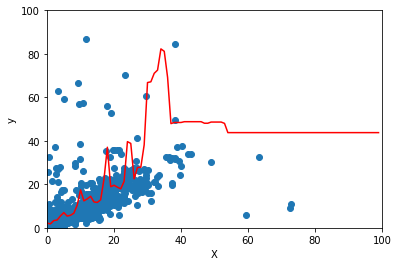

In [13]:
plt.scatter(X,y)
plt.plot(X_pred,yhat, 'r-')

plt.xlim([0,100])
plt.ylim([0,100])

plt.xlabel('X')
plt.ylabel('y');

From this we can see that we are probably over-fitting the data to the model.  $k$ is too small, most likely.  

Now, going forward we need a way to cross-validate.

## Partitioning the data for cross validation
First, we need to create partitions of data

If we just partitioned the data into $K$ folds in the order they occur, we might inadvertently pick up correlation between variables in their order of occurrence.  

For example suppose you're predicting temperature for tomorrow based on today's temperatures.  If you sample just from the morning then you'll get a bias downward since temperatures are typically lower then.  

But it's also important to use disjoint folds -- that is, no two folds should contain the same data.  Why?  Because we want to make sure that when we reserve a fold for testing data those data won't also appear in the training set.

But how can we do this?  
- draw random numbers without replacement
- randomly "shuffle" the data, then make the first block (roughly $n/K$ data points).

Let's try a shuffle.  Numpy has a built in command for that.  

In [14]:
#delete for in-lecture notebook
x = np.arange(15)
print(x)
np.random.shuffle(x)
print(x)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
[12  1  6  7 10  0  9  2  8  4  5 11  3 14 13]


If you run that over and over you'll see the order of the second array changes.  You can stop that with a seed, e.g. `np.random.seed(3)`.  You can put any number in place of the `3` above.

What to do next?  We need to partition the data.  If we want $K$ folds, then we'll need to create $K$ partitions.  Let's try K = 4.

In [15]:
#delete for in-lecture notebook
K = 4
# next we'll create an empty matrix, and then fill it with indices denoting fold membership

# d1 is the number of observations in each fold
d1 = int(np.ceil(len(x)/K))

# d2 is the number of folds
d2 = K

x_partitioned = np.full((d1, d2), np.nan)

for i in range(K):
    x_partitioned[0:len(x[i::K]),i] = x[i::K]

In [16]:
#delete for in-lecture notebook
x_partitioned

array([[12.,  1.,  6.,  7.],
       [10.,  0.,  9.,  2.],
       [ 8.,  4.,  5., 11.],
       [ 3., 14., 13., nan]])

Now you can see we have an array with randomly placed entries from the original series.  Each of these can be thought of as a fold.

## Streamlining K-fold with scikit-learn:
Now let's think about how to fit models and construct errors for each.

Because we're going to be splitting both the input and response variables, I'm going to transition now to using a built-in class from scikit-learn: 

In [17]:
# delete for in-lecture notebook
import sklearn.model_selection as skm
from sklearn.metrics import mean_squared_error

In [18]:
# delete for in-lecture notebook
kf = skm.KFold(n_splits=K, shuffle=True, random_state=4) 

That makes an object that can put data into K splits.  

Let's redefine $x$ so it's ordered.  This will allow us to see how it works:

In [19]:
# delete for in-lecture notebook
x = np.arange(15)

In [20]:
# delete for in-lecture notebook
for train, test in kf.split(x):
    print('train: %s, test: %s' % (train, test))

train: [ 1  2  4  5  7  8  9 10 11 13 14], test: [ 0  3  6 12]
train: [ 0  1  3  5  6  7  8 10 12 13 14], test: [ 2  4  9 11]
train: [ 0  2  3  4  5  6  7  9 10 11 12], test: [ 1  8 13 14]
train: [ 0  1  2  3  4  6  8  9 11 12 13 14], test: [ 5  7 10]


In [21]:
K = 5
kf = skm.KFold(n_splits=K, shuffle=True, random_state=8) 

for train, test in kf.split(x):
    print('train: %s, test: %s' % (train, test))

train: [ 0  1  3  4  5  7  8  9 10 12 13 14], test: [ 2  6 11]
train: [ 0  1  2  3  4  5  6  7  8  9 11 14], test: [10 12 13]
train: [ 1  2  3  4  5  6  8  9 10 11 12 13], test: [ 0  7 14]
train: [ 0  1  2  3  4  6  7 10 11 12 13 14], test: [5 8 9]
train: [ 0  2  5  6  7  8  9 10 11 12 13 14], test: [1 3 4]


Let's implement all this for model selection:

In [22]:
X = np.array(hilltop_resamp).reshape(-1,1)
y = np.array(kirchy_resamp)

k_min = 10
k_max = 200
step = 10
k_vect = np.arange(k_min, k_max, step)
n_steps = len(k_vect)
MSE_test = np.zeros(n_steps)
MSE_train = np.zeros(n_steps)
for i in range(len(k_vect)):
    MSE_test[i] = 0
    MSE_train[i] = 0
    neigh = KNeighborsRegressor(n_neighbors=k_vect[i])
    for train, test in kf.split(X):  # test and train will be indices we can use to partition the data
        neigh.fit(X[train], y[train]) 
        MSE_test[i] = MSE_test[i]+ 1/K * np.mean((neigh.predict(X[test]) - y[test])**2)
        MSE_train[i] = MSE_train[i]+ 1/K * np.mean((neigh.predict(X[train]) - y[train])**2)
        
test_train = np.array([MSE_test, MSE_train]).transpose()

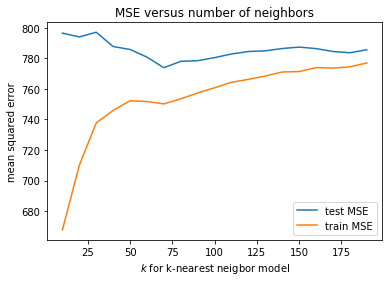

In [23]:
plt.plot(k_vect, test_train)
plt.xlabel('$k$ for k-nearest neigbor model')
plt.title('MSE versus number of neighbors')
plt.ylabel('mean squared error');
plt.legend(['test MSE', 'train MSE']);
plt.savefig('CV_MSE_vs_NumberNeighbors', dpi = 300)

## Building the final model
Now that we know the right flexibility for the model (70 neighbors), we can build the final model with *all* the data.

In [24]:
# delete for in-lecture notebook
k_opt = k_vect[MSE_test == np.min(MSE_test)][0]
k_opt

70

In [25]:
final_knn = KNeighborsRegressor(n_neighbors=k_opt)
final_knn.fit(X, y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=70, p=2,
          weights='uniform')

## How well does outdoor air quality predict indoor air quality?
Now let's come back to the question: how well does outdoor air quality predict indoor air quality?

Let's do the following
1. Build a model that predicts outdoor air at one location from outdoor air at another.
2. Build a model that predicts indoor air at one location from outdoor air at another.
3. Compare performance of the two.  

In [26]:
X = np.array(hilltop_resamp).reshape(-1,1)
y_kirchy = np.array(kirchy_resamp)

final_knn = KNeighborsRegressor(n_neighbors=k_opt)
final_knn.fit(X, y_kirchy)

kirchy_from_hilltop = final_knn 
kirchy_pred = kirchy_from_hilltop.predict(X_pred)

In [27]:
y_westoak = np.array(westoak_resamp)

final_knn = KNeighborsRegressor(n_neighbors=k_opt)
final_knn.fit(X, y_westoak)

westoak_from_hilltop = final_knn
westoak_pred = westoak_from_hilltop.predict(X_pred)

In [28]:
X_westoak = np.array(westoak_resamp).reshape(-1,1)

final_knn = KNeighborsRegressor(n_neighbors=k_opt)
final_knn.fit(X_westoak, y_kirchy)

kirchy_from_westoak = final_knn
kirchy_from_westoak_pred = kirchy_from_westoak.predict(X_pred)

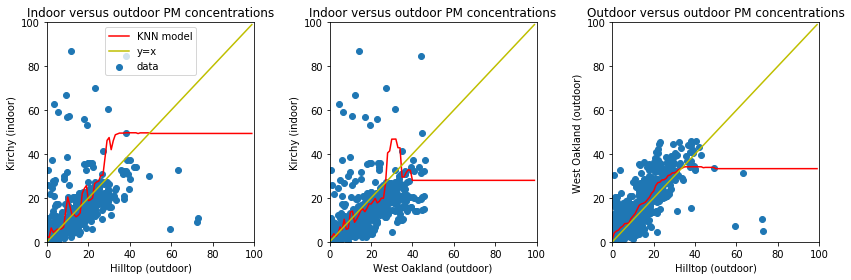

In [29]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(131)


# first subplot -- indoor (kirchy) vs outdoor (hilltop)
plt.scatter(X,y_kirchy)
plt.plot(X_pred, kirchy_pred, 'r-')
plt.plot(X_pred, X_pred, 'y')

plt.xlim([0,100])
plt.ylim([0,100])

plt.xlabel('Hilltop (outdoor)')
plt.ylabel('Kirchy (indoor)');
plt.title('Indoor versus outdoor PM concentrations');

plt.legend([ 'KNN model', 'y=x', 'data'])


# second subplot -- indoor (kirchy) vs outdoor (westoak)
ax2 = f.add_subplot(132)

plt.scatter(X_westoak,y_kirchy)
plt.plot(X_pred, kirchy_from_westoak_pred, 'r-')
plt.plot(X_pred, X_pred, 'y')

plt.xlim([0,100])
plt.ylim([0,100])

plt.xlabel('West Oakland (outdoor)')
plt.ylabel('Kirchy (indoor)');

plt.title('Indoor versus outdoor PM concentrations');

# third subplot -- vs outdoor (westoak) vs outdoor (hilltop)
ax3 = f.add_subplot(133)

plt.scatter(X,y_westoak)
plt.plot(X_pred, westoak_pred, 'r-')
plt.plot(X_pred, X_pred, 'y')

plt.xlim([0,100])
plt.ylim([0,100])

plt.ylabel('West Oakland (outdoor)')
plt.xlabel('Hilltop (outdoor)');

plt.title('Outdoor versus outdoor PM concentrations');

# clean up sizing
plt.tight_layout();
plt.savefig('in_vs_out.png', dpi = 300)

What can we observe from the plots?
1. Indoor appears to be *usually* lower than Hilltop outdoor -- look at scatter points, the mass appears below the y=x line.
3. But the indoor extremes are really extreme -- this pulls the estimates up.
2. West Oakland outdoor is on average higher than Hilltop outdoor
4. When the data "run out" the model is systematically high (high values of outdoor predictor)